In [67]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import cmocean
import cartopy.crs as ccrs

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import linear_model
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

# Summary 

This notebook opens up the NOBM-OASIM dataset with the added PC scores, standardizes all the environmental variables, and creates new datasets for each phyto group > 0.01 with added logged phyto concentrations. Then, data is split into training and testing and for each phyto group, a backward stepwise regression is used to select most important variables (PC scores and env variables). Selected variables, coefficients, and the int are saved as a .csv for each. 


# Read in dataset w/ scores

In [3]:
rrs_xds = xr.open_dataset('/glusteruser/awindled/ALL_NOBM_OASIM_data_2020_w_scores.nc', decode_times=False)
rrs_xds

<xarray.Dataset>
Dimensions:         (months: 12, lat: 234, lon: 288, wavelength: 401)
Coordinates:
  * months          (months) float32 0.0 1.0 2.0 3.0 4.0 ... 8.0 9.0 10.0 11.0
  * lat             (lat) float32 -84.0 -83.33 -82.67 -82.0 ... 70.0 70.67 71.33
  * lon             (lon) float32 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * wavelength      (wavelength) int64 350 351 352 353 354 ... 747 748 749 750
    wv              (wavelength) int64 ...
Data variables: (12/55)
    tot             (months, lat, lon) float32 ...
    chl             (months, lat, lon) float32 ...
    dia             (months, lat, lon) float32 ...
    coc             (months, lat, lon) float32 ...
    cya             (months, lat, lon) float32 ...
    din             (months, lat, lon) float32 ...
    ...              ...
    PC_3            (months, lat, lon) float64 ...
    PC_4            (months, lat, lon) float64 ...
    PC_5            (months, lat, lon) float64 ...
    PC_6            (months, lat, lon) float64 ...
    PC_7            (months, lat, lon) float64 ...
    PC_8            (months, lat, lon) float64 ...

# Standardize env variables (values range from 0-1)

In [4]:
env_vars = ['pic', 'irn', 'rno', 'h', 'sil', 'dtc', 'cdc', 't', 's', 'par']
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

for i in range(len(env_vars)):
    foo = rrs_xds[env_vars[i]].values.reshape(12*234*288)
    foo = scaler.fit_transform(foo.reshape(-1, 1))
    rrs_xds[env_vars[i]].values = foo.reshape(12,234,288)

# Convert data into pandas dataframe

In [5]:
variables = list(rrs_xds.keys())[0:18]
variables.extend(['aph440_aph676', 'aph440_ap440', 'a_cdoc_443', 'bbp_s_440_555'])
variables.extend(list(rrs_xds.keys())[47:68])
variables.remove("ice")

rrs_xds_dat = rrs_xds[variables].to_dataframe()
rrs_xds_dat

tot  chl  dia  coc  cya  din  pha  pic  irn  rno  \
months lat        lon                                                         
0.0    -84.000000 -180.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                  -178.75  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                  -177.50  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                  -176.25  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                  -175.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...                        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
11.0    71.333336  173.75  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   175.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   176.25  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   177.50  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   178.75  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                           ...  a_cdoc_443  bbp_s_440_555  PC_1  PC_2  PC_3  \
months lat        lon      ...                                                
0.0    -84.000000 -180.00  ...         NaN            NaN   0.0   0.0   0.0   
                  -178.75  ...         NaN            NaN   0.0   0.0   0.0   
                  -177.50  ...         NaN            NaN   0.0   0.0   0.0   
                  -176.25  ...         NaN            NaN   0.0   0.0   0.0   
                  -175.00  ...         NaN            NaN   0.0   0.0   0.0   
...                        ...         ...            ...   ...   ...   ...   
11.0    71.333336  173.75  ...         NaN            NaN   0.0   0.0   0.0   
                   175.00  ...         NaN            NaN   0.0   0.0   0.0   
                   176.25  ...         NaN            NaN   0.0   0.0   0.0   
                   177.50  ...         NaN            NaN   0.0   0.0   0.0   
                   178.75  ...         NaN            NaN   0.0   0.0   0.0   

                           PC_4  PC_5  PC_6  PC_7  PC_8  
months lat        lon                                    
0.0    -84.000000 -180.00   0.0   0.0   0.0   0.0   0.0  
                  -178.75   0.0   0.0   0.0   0.0   0.0  
                  -177.50   0.0   0.0   0.0   0.0   0.0  
                  -176.25   0.0   0.0   0.0   0.0   0.0  
                  -175.00   0.0   0.0   0.0   0.0   0.0  
...                         ...   ...   ...   ...   ...  
11.0    71.333336  173.75   0.0   0.0   0.0   0.0   0.0  
                   175.00   0.0   0.0   0.0   0.0   0.0  
                   176.25   0.0   0.0   0.0   0.0   0.0  
                   177.50   0.0   0.0   0.0   0.0   0.0  
                   178.75   0.0   0.0   0.0   0.0   0.0  

[808704 rows x 29 columns]

# drop nans for SequentialFeatureSelector function

In [6]:
rrs_xds_dat = rrs_xds_dat.dropna()
rrs_xds_dat

tot           chl           dia           coc  \
months lat        lon                                                           
0.0    -78.000000 -180.00  0.435280  1.302277e-32  5.790093e-08  1.836052e-12   
                  -178.75  0.442183  1.800597e-32  9.011884e-08  3.257872e-12   
                  -177.50  0.481909  2.523838e-32  1.144635e-07  3.826336e-12   
                  -176.25  0.488594  3.730429e-32  1.733026e-07  5.143830e-12   
                  -175.00  0.497206  6.912371e-32  2.431619e-07  7.160853e-12   
...                             ...           ...           ...           ...   
11.0    70.666664  11.25   0.012477  3.297888e-26  9.077619e-03  3.398656e-03   
                   12.50   0.012505  3.692610e-27  9.195263e-03  3.309032e-03   
                   13.75   0.012494  4.220176e-28  9.203578e-03  3.290530e-03   
                   15.00   0.012181  6.779949e-29  9.030103e-03  3.151193e-03   
                   16.25   0.012571  1.280946e-29  9.533199e-03  3.037988e-03   

                                    cya           din           pha       pic  \
months lat        lon                                                           
0.0    -78.000000 -180.00  6.897307e-27  2.209340e-32  4.352803e-01  0.087553   
                  -178.75  1.139934e-26  3.322602e-32  4.421830e-01  0.084408   
                  -177.50  2.645717e-26  3.457083e-32  4.819090e-01  0.082188   
                  -176.25  3.336013e-26  4.394092e-32  4.885941e-01  0.037648   
                  -175.00  6.450341e-26  5.779970e-32  4.972054e-01  0.037325   
...                                 ...           ...           ...       ...   
11.0    70.666664  11.25   2.053559e-32  6.851186e-07  1.198069e-16  0.034525   
                   12.50   2.029524e-32  4.639312e-07  8.584605e-18  0.033835   
                   13.75   2.029467e-32  2.601123e-07  4.475222e-19  0.033764   
                   15.00   2.029227e-32  1.060638e-07  2.997065e-20  0.032094   
                   16.25   2.034517e-32  4.291214e-08  2.179896e-21  0.029447   

                                irn       rno  ...  a_cdoc_443  bbp_s_440_555  \
months lat        lon                          ...                              
0.0    -78.000000 -180.00  0.007332  0.201124  ...    0.012361       1.468672   
                  -178.75  0.006864  0.196557  ...    0.014316       1.461740   
                  -177.50  0.007734  0.213100  ...    0.016593       1.445815   
                  -176.25  0.007556  0.221613  ...    0.033314       1.327958   
                  -175.00  0.007825  0.228030  ...    0.033840       1.324890   
...                             ...       ...  ...         ...            ...   
11.0    70.666664  11.25   0.023712  0.263522  ...    0.016708       1.656894   
                   12.50   0.022787  0.258618  ...    0.016709       1.656871   
                   13.75   0.022105  0.255697  ...    0.016710       1.657081   
                   15.00   0.024089  0.287036  ...    0.016710       1.657078   
                   16.25   0.019779  0.243204  ...    0.016712       1.652229   

                               PC_1      PC_2      PC_3      PC_4      PC_5  \
months lat        lon                                                         
0.0    -78.000000 -180.00  1.360266 -0.191872 -0.897007 -0.420749  1.557226   
                  -178.75  1.324405 -0.234275 -0.944701 -0.471543  1.505242   
                  -177.50  1.286334 -0.277437 -0.992318 -0.523330  1.450917   
                  -176.25  1.088890 -0.500141 -1.230536 -0.763205  1.232905   
                  -175.00  1.085033 -0.505047 -1.235329 -0.768063  1.228512   
...                             ...       ...       ...       ...       ...   
11.0    70.666664  11.25   1.237665 -0.349772 -1.066330 -0.573227  1.465386   
                   12.50   1.236489 -0.350209 -1.067340 -0.574370  1.464955   
                   13.75   1.236332 -0.350629 -1.067371 -0.575595  1.464647   
 

# Filter dataset so each phyto group only has values > 0.01. 
## Prints the percentage of non-nan data


In [28]:
phyto_vars = ['tot', 'chl', 'dia', 'coc', 'cya', 'din', 'pha'] 

for i in range(len(phyto_vars)):
    rrs_xds_dat[phyto_vars[i]][rrs_xds_dat[phyto_vars[i]] < 0.01] = np.nan
    print(phyto_vars[i], (rrs_xds_dat[phyto_vars[i]].count() / 487726)*100)   

tot 96.88349606131311
chl 32.26688755571776
dia 42.15420133435577
coc 36.08316964853216
cya 45.516334991368105
din 0.9849792711481447
pha 18.978893887141552


# Correlation plot of phyto groups and env data/ PC scores

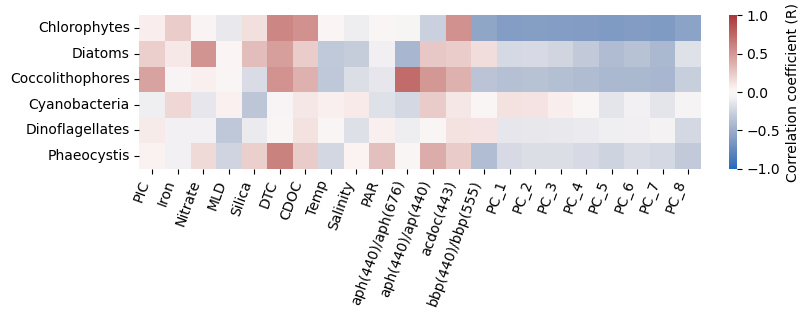

In [37]:
fig, axs = plt.subplots(figsize=(8,4), sharey=True, layout='compressed')

phyto_vars = ['tot', 'chl', 'dia', 'coc', 'cya', 'din', 'pha'] 

env_vars = list(rrs_xds.keys())[7:18]
env_vars.extend(['aph440_aph676', 'aph440_ap440', 'a_cdoc_443', 'bbp_s_440_555'])
env_vars.remove('ice')
env_vars.extend(['PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8'])

sns.heatmap(rrs_xds_dat.corr().loc[phyto_vars[1:], env_vars], annot=False, vmin=-1, vmax=1,
            cmap='vlag', square=True, cbar_kws={'label': 'Correlation coefficient (R)'})

axs.set_yticklabels(['Chlorophytes', 'Diatoms', 'Coccolithophores', 'Cyanobacteria', 
                     'Dinoflagellates', 'Phaeocystis'], rotation=0)

axs.set_xticklabels(['PIC', 'Iron', 'Nitrate', 'MLD', 'Silica', 'DTC', 'CDOC', 'Temp', 
                     'Salinity', 'PAR', 'aph(440)/aph(676)', 'aph(440)/ap(440)', 
                     'acdoc(443)', 'bbp(440)/bbp(555)', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 
                     'PC_5', 'PC_6', 'PC_7', 'PC_8'], rotation=70, ha='right')

#plt.show()
plt.savefig('/glusteruser/awindled/PCC_OASIM_figs/corr_plot.png', dpi=300) 


# Make new datasets for each phyto group that filter phyto conc less than 0.01

In [126]:
tot_dat = rrs_xds_dat[rrs_xds_dat.tot > 0.01]
tot_dat.name = 'tot_dat'
chl_dat = rrs_xds_dat[rrs_xds_dat.chl > 0.01]
chl_dat.name = 'chl_dat'
dia_dat = rrs_xds_dat[rrs_xds_dat.dia > 0.01]
dia_dat.name = 'dia_dat'
coc_dat = rrs_xds_dat[rrs_xds_dat.coc > 0.01]
coc_dat.name = 'coc_dat'
cya_dat = rrs_xds_dat[rrs_xds_dat.cya > 0.01]
cya_dat.name = 'cya_dat'
din_dat = rrs_xds_dat[rrs_xds_dat.din > 0.01]
din_dat.name = 'din_dat'
pha_dat = rrs_xds_dat[rrs_xds_dat.pha > 0.01]
pha_dat.name = 'pha_dat'

# Make new variables of logged phyto groups

In [127]:
tot_dat['log_tot'] = np.log10(tot_dat.tot)
chl_dat['log_chl'] = np.log10(chl_dat.chl)
dia_dat['log_dia'] = np.log10(dia_dat.dia)
coc_dat['log_coc'] = np.log10(coc_dat.coc)
cya_dat['log_cya'] = np.log10(cya_dat.cya)
din_dat['log_din'] = np.log10(din_dat.din)
pha_dat['log_pha'] = np.log10(pha_dat.pha)

In [128]:
print(len(tot_dat), (len(tot_dat)/ 487726)*100)
print(len(chl_dat), (len(chl_dat)/ 487726)*100)
print(len(dia_dat), (len(dia_dat)/ 487726)*100)
print(len(coc_dat), (len(coc_dat)/ 487726)*100)
print(len(cya_dat), (len(cya_dat)/ 487726)*100)
print(len(din_dat), (len(din_dat)/ 487726)*100)
print(len(pha_dat), (len(pha_dat)/ 487726)*100)

472526 96.88349606131311
157374 32.26688755571776
205597 42.15420133435577
175987 36.08316964853216
221995 45.516334991368105
4804 0.9849792711481447
92565 18.978893887141552


# Look at distribution of phyto group conc

<Axes: title={'center': 'log_pha'}, ylabel='Frequency'>

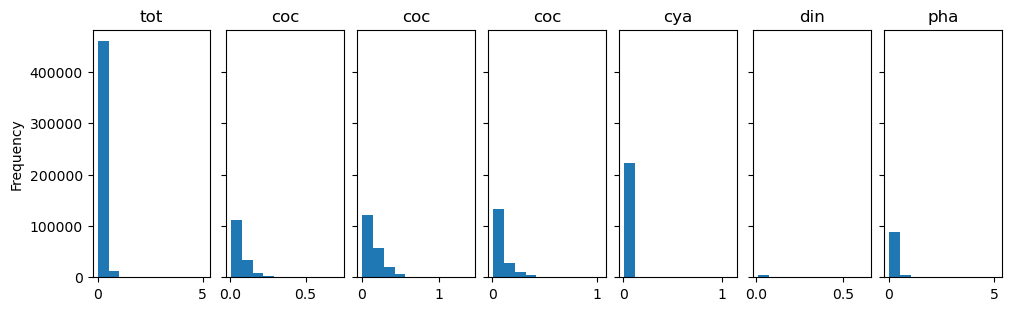

<Figure size 640x480 with 0 Axes>

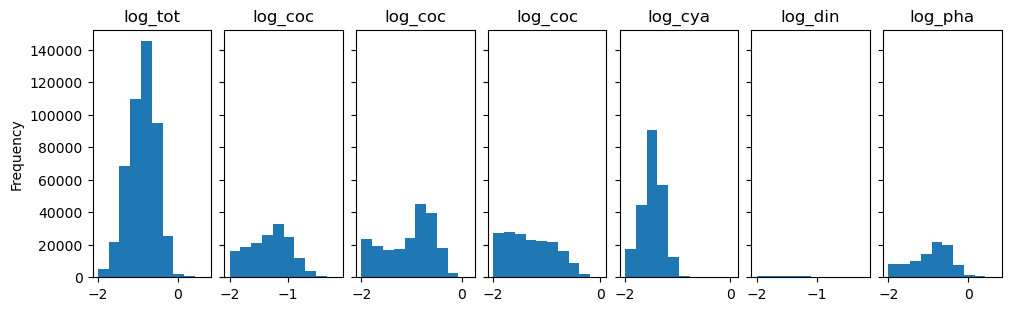

In [129]:
#histograms of phyto groups
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(10,3), sharey=True, layout='compressed')
axs = axs.ravel()

tot_dat.tot.plot.hist(ax=axs[0], title='tot')
chl_dat.chl.plot.hist(ax=axs[1], title='coc')
dia_dat.dia.plot.hist(ax=axs[2], title='coc')
coc_dat.coc.plot.hist(ax=axs[3], title='coc')
cya_dat.cya.plot.hist(ax=axs[4], title='cya')
din_dat.din.plot.hist(ax=axs[5], title='din')
pha_dat.pha.plot.hist(ax=axs[6], title='pha')

#histograms of logged phyto groups
plt.figure(2)
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(10,3), sharey=True, layout='compressed')
axs = axs.ravel()

tot_dat.log_tot.plot.hist(ax=axs[0], title='log_tot')
chl_dat.log_chl.plot.hist(ax=axs[1], title='log_coc')
dia_dat.log_dia.plot.hist(ax=axs[2], title='log_coc')
coc_dat.log_coc.plot.hist(ax=axs[3], title='log_coc')
cya_dat.log_cya.plot.hist(ax=axs[4], title='log_cya')
din_dat.log_din.plot.hist(ax=axs[5], title='log_din')
pha_dat.log_pha.plot.hist(ax=axs[6], title='log_pha')

# The MLR function:
- performs sequential feature selector on all data to find most important variables
- perform 100 k-fold cross validation to obtain predicted results and goodness of fit metrics
- plot actual vs predicted (logged and unlogged)
- save selected_features, mean/std coefs, mean int, and goodness of fit metrics as .csv


In [146]:
def MLR(phyto_dat):

    phyto = phyto_dat.name[0:3]
    print(phyto)

    # select columns that are x variables (all columns except phyto groups)
    phyto_dat_x = phyto_dat.iloc[:,7:29]
    
    #apply backward stepwise selection to all data
    sfs = SequentialFeatureSelector(linear_model.LinearRegression(),
                                n_features_to_select='auto',
                                direction='backward', scoring = 'r2', 
                                n_jobs=40, cv=5) 
    
    phyto_selected_features = sfs.fit(phyto_dat_x, phyto_dat['log_'+phyto])
    phyto_selected_features = phyto_dat_x.loc[:, phyto_selected_features.support_].columns
    print(phyto_selected_features)
    
    coefs_all = []
    coefs_std_all = []
    intercept_all = []
    r2_scores = []
    bias_scores = []
    mae_scores = []
    
    #100 fold cross validation splitting data into 75% train, 25% test
    kf = RepeatedKFold(n_splits=4, n_repeats=100) 

    for train_index, test_index in kf.split(phyto_dat_x):
        
        # Split the data into training and test sets
        x_train, x_test = phyto_dat_x.iloc[train_index], phyto_dat_x.iloc[test_index]
        y_train, y_test = phyto_dat['log_'+phyto].iloc[train_index], phyto_dat['log_'+phyto].iloc[test_index]
        
        x_train_selected = x_train.loc[:, phyto_selected_features]
        
        linreg=linear_model.LinearRegression()
        linreg.fit(x_train_selected, y_train)
        y_pred = linreg.predict(x_test.loc[:, phyto_selected_features])
        
        coefs = linreg.coef_
        intercept = linreg.intercept_
        r2score = r2_score(y_test, y_pred)
        bias = np.nansum((y_pred - y_test))/len(y_test)
        mae = np.nansum(np.abs((y_pred - y_test)))/len(y_test)
        
        coefs_all.append(coefs)
        intercept_all.append(intercept)
        r2_scores.append(r2score)
        bias_scores.append(bias)
        mae_scores.append(mae)
  
    coefs = np.mean(coefs_all, axis=0)
    print('coefs_mn:', coefs)
    coefs_std = np.std(coefs_all, axis=0)
    print('coefs_std:', coefs_std)
    int = np.mean(intercept_all)
    print('int:', int)
    r2 = np.mean(r2_scores)            
    print('mean r2:', r2)
    bias = np.mean(bias_scores)
    print('mean bias:', bias)
    mae = np.mean(mae_scores)
    print('mean mae:', mae)
    
    fig, ax = plt.subplots()
    scatter = ax.scatter(y_test, y_pred)
    ax.set_xlabel('Logged Actual')
    ax.set_ylabel('Logged Predicted')
    ax.axline((0, 0), slope=1)
    plt.show()
    
    plt.figure(2)
    fig, ax = plt.subplots()
    scatter = ax.scatter((10**y_test), (10**y_pred))
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.axline((0, 0), slope=1)
    plt.show()
    
    phyto_dat = pd.DataFrame({'selected_features':phyto_selected_features, 'coefs_mn':coefs, 'coefs_std':coefs_std,
                  'int':np.array([int]*len(phyto_selected_features))})
    phyto_dat.to_csv('/glusteruser/awindled/' + phyto + '.csv')


# Apply MLR function to all phyto groups

tot
Index(['pic', 'h', 'dtc', 't', 'aph440_aph676', 'aph440_ap440',
       'bbp_s_440_555', 'PC_1', 'PC_3', 'PC_5', 'PC_6'],
      dtype='object')
coefs_mn: [  2.6240847    0.08369422   0.35215608   0.15377714  -0.21030857
   2.34032966  -0.35635743  14.84053103 -23.55000965  -8.30151097
  15.5947997 ]
coefs_std: [0.0187632  0.00061954 0.00666694 0.00222487 0.00036626 0.00287924
 0.00153014 0.08148747 0.11389165 0.01616615 0.04813147]
int: -16.81899908915285
mean r2: 0.9437692736226754
mean bias: 1.9752773084214622e-07
mean mae: 0.05218656448410895


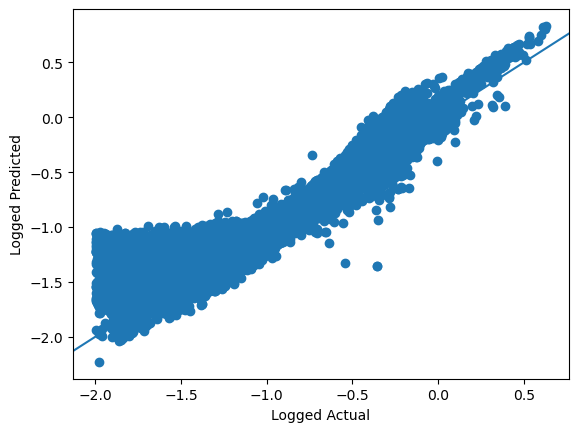

<Figure size 640x480 with 0 Axes>

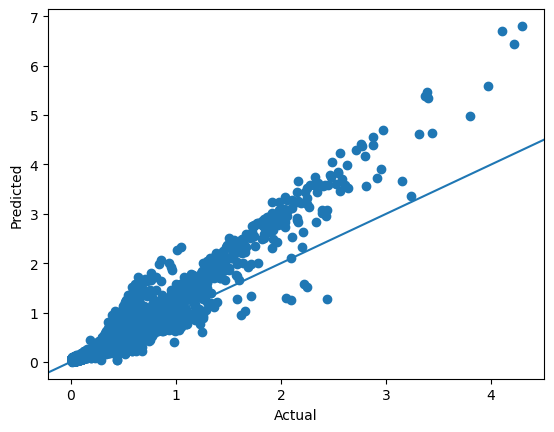

chl
Index(['pic', 'rno', 't', 'aph440_ap440', 'bbp_s_440_555', 'PC_1', 'PC_2',
       'PC_4', 'PC_5', 'PC_6', 'PC_8'],
      dtype='object')
coefs_mn: [  6.04688873  -1.66058821   1.13189969  -3.1159389   -0.71764464
  81.26427371 -64.56981959 -82.47481633 -40.181827    83.59807866
  47.21549111]
coefs_std: [0.22772846 0.01548998 0.00456559 0.03695415 0.02513095 1.59313921
 1.39228652 1.81865028 0.69762715 1.80236509 0.35412113]
int: -15.733991188066982
mean r2: 0.7793981700817483
mean bias: 9.414387592927382e-06
mean mae: 0.11733170082284732


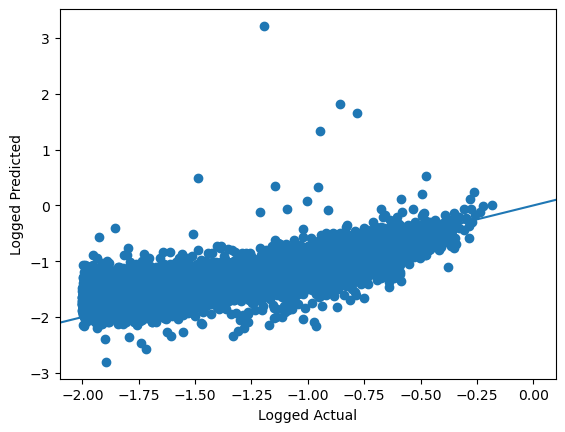

<Figure size 640x480 with 0 Axes>

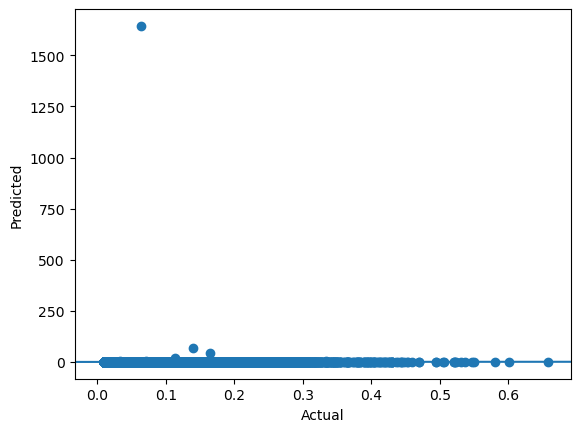

dia
Index(['pic', 'irn', 't', 's', 'aph440_aph676', 'aph440_ap440',
       'bbp_s_440_555', 'PC_1', 'PC_4', 'PC_5', 'PC_7'],
      dtype='object')
coefs_mn: [  7.68694832  -4.26298762  -0.31978311   0.29735857  -0.56629159
   1.01347966   0.53356453 -14.37680972  12.5021982   35.08129414
 -34.30434903]
coefs_std: [0.02771588 0.02528723 0.00180041 0.00167383 0.00085455 0.00809167
 0.00450844 0.06964783 0.09351686 0.08540463 0.10403682]
int: -1.353057916058539
mean r2: 0.8831262784248031
mean bias: 2.7461235430158787e-06
mean mae: 0.11758848589527013


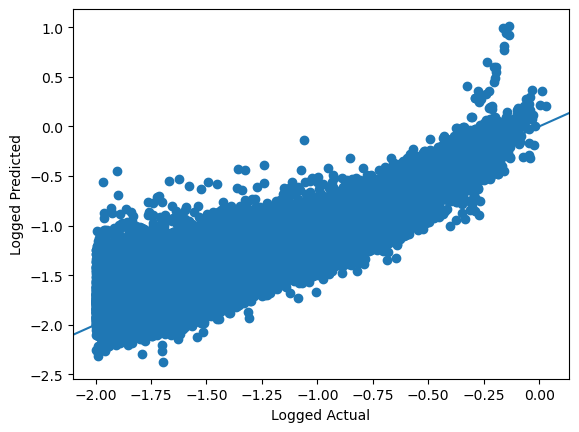

<Figure size 640x480 with 0 Axes>

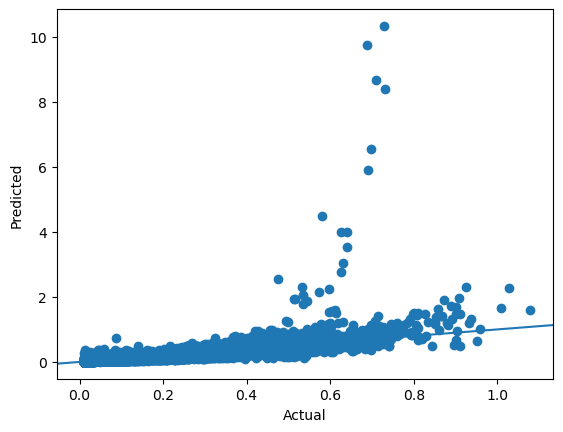

coc
Index(['pic', 'sil', 't', 'aph440_aph676', 'aph440_ap440', 'bbp_s_440_555',
       'PC_1', 'PC_4', 'PC_5', 'PC_7', 'PC_8'],
      dtype='object')
coefs_mn: [  1.60086721  -0.59274018  -0.12425144   0.38916543   1.92608364
  -0.35962004 -13.26406967  21.72389654  24.0505754  -26.46069311
 -13.7578495 ]
coefs_std: [0.0203852  0.00991141 0.00152232 0.00112236 0.01212091 0.00490437
 0.23652268 0.38200526 0.38835862 0.44249182 0.18132564]
int: 6.89407918015494
mean r2: 0.9121430131840771
mean bias: 1.927950735318848e-06
mean mae: 0.10358674893620615


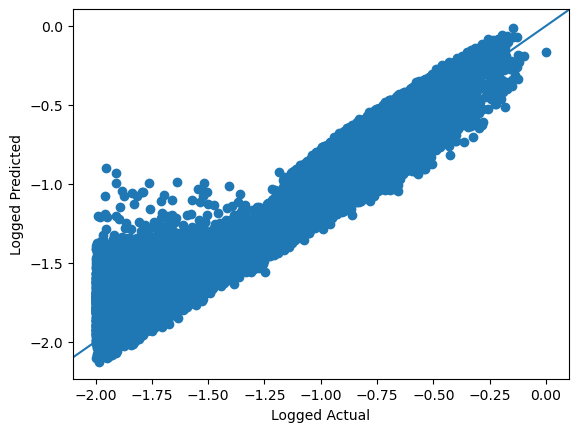

<Figure size 640x480 with 0 Axes>

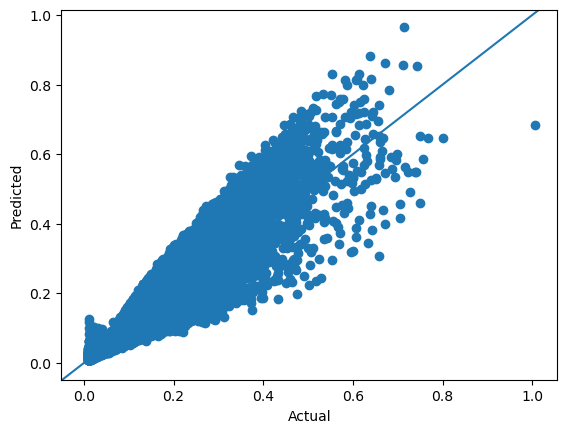

cya
Index(['pic', 'rno', 'sil', 'dtc', 'aph440_ap440', 'a_cdoc_443',
       'bbp_s_440_555', 'PC_2', 'PC_5', 'PC_7', 'PC_8'],
      dtype='object')
coefs_mn: [-8.50446364 -1.94293268 -0.74205097 -1.96221628  1.04156761 20.71899307
  0.12191272  6.79785059 -9.83668076  7.18947543 -6.46442865]
coefs_std: [0.10299277 0.06638669 0.02197492 0.04393017 0.01751408 0.91929013
 0.01017102 0.0220524  0.32342332 0.21534673 0.17470414]
int: 6.964494919537021
mean r2: 0.9094286576878372
mean bias: -1.7890684225330585e-06
mean mae: 0.03915701202283052


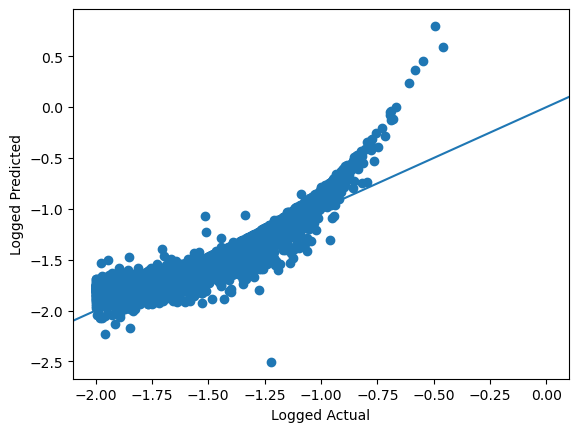

<Figure size 640x480 with 0 Axes>

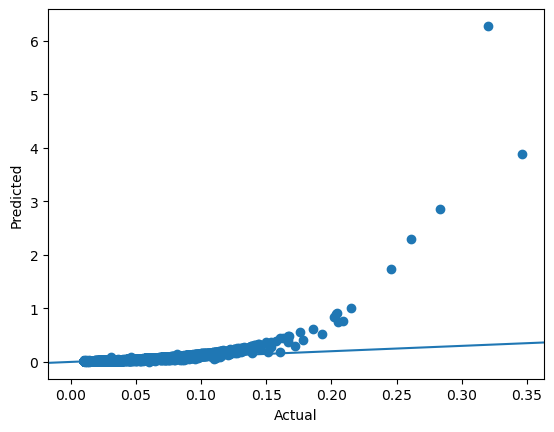

din
Index(['pic', 'h', 'sil', 'par', 'aph440_aph676', 'aph440_ap440', 'PC_1',
       'PC_2', 'PC_6', 'PC_7', 'PC_8'],
      dtype='object')
coefs_mn: [ -2.31015576  -0.81222894  -0.31965022  -0.1004663   -0.44896066
   4.90278573  11.65526231 -31.03917262  41.20866608 -18.6393714
 -16.73750665]
coefs_std: [0.19315718 0.0231693  0.02161474 0.01205646 0.00767136 0.08310939
 4.13580852 5.98431008 5.19447989 3.34285504 0.50842503]
int: 21.8816061729636
mean r2: 0.5773801172268791
mean bias: 7.175874957008932e-05
mean mae: 0.20803038580863473


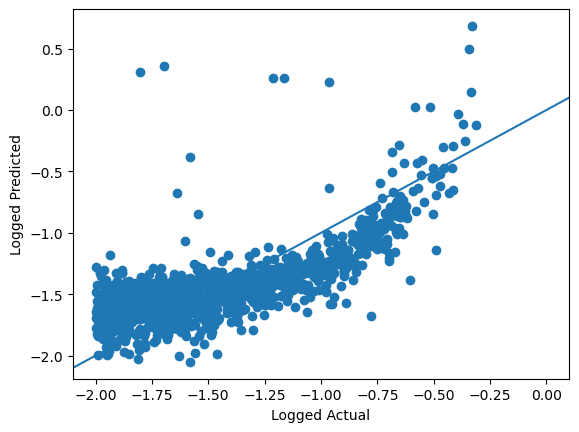

<Figure size 640x480 with 0 Axes>

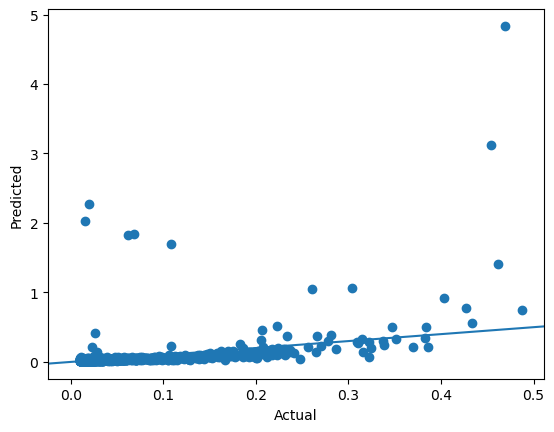

pha
Index(['pic', 'h', 'dtc', 'cdc', 't', 'par', 'aph440_aph676', 'aph440_ap440',
       'PC_1', 'PC_5', 'PC_8'],
      dtype='object')
coefs_mn: [ 5.71293357 -0.09529098  0.98831636 -3.22855328 -2.23015331  0.24245324
 -0.52565686  2.52887056 -9.06641815  6.07883183 -5.70553316]
coefs_std: [0.05046736 0.00133322 0.00797694 0.04972872 0.01974991 0.00339268
 0.00983702 0.00406972 0.0759886  0.02345247 0.05928523]
int: 0.19205534045345415
mean r2: 0.8448147047748464
mean bias: -2.2607208919202367e-08
mean mae: 0.14319312721017707


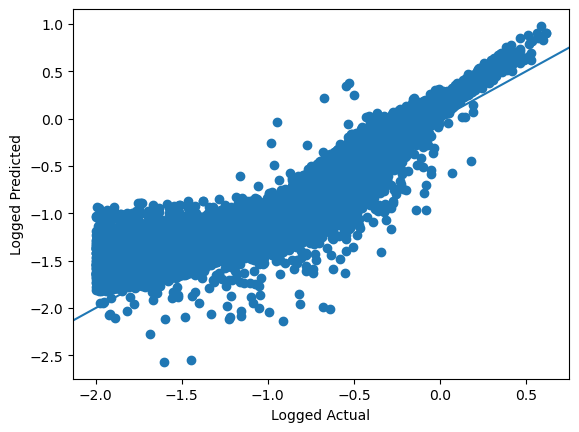

<Figure size 640x480 with 0 Axes>

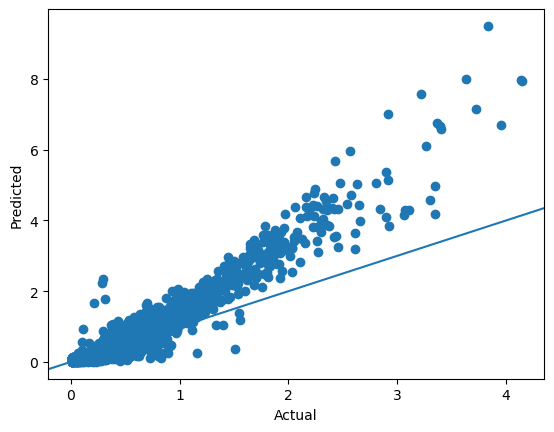

In [147]:
phyto_dats = [tot_dat, chl_dat, dia_dat, coc_dat, cya_dat, din_dat, pha_dat] 

for i in range(len(phyto_dats)):
    MLR(phyto_dat=phyto_dats[i]) 


# Same function but take away env variables

In [153]:
def MLR_no_env(phyto_dat):

    phyto = phyto_dat.name[0:3]
    print(phyto)

    # select columns that are x variables (all columns except phyto groups)
    phyto_dat_x = phyto_dat.iloc[:,21:29]

    #apply backward stepwise selection to all data
    sfs = SequentialFeatureSelector(linear_model.LinearRegression(),
                                n_features_to_select='auto',
                                direction='backward', scoring = 'r2', 
                                n_jobs=40, cv=5) 
    
    phyto_selected_features = sfs.fit(phyto_dat_x, phyto_dat['log_'+phyto])
    phyto_selected_features = phyto_dat_x.loc[:, phyto_selected_features.support_].columns
    print(phyto_selected_features)
    
    coefs_all = []
    coefs_std_all = []
    intercept_all = []
    r2_scores = []
    bias_scores = []
    mae_scores = []
    
    #100 fold cross validation splitting data into 75% train, 25% test
    kf = RepeatedKFold(n_splits=4, n_repeats=100) 

    for train_index, test_index in kf.split(phyto_dat_x):
        
        # Split the data into training and test sets
        x_train, x_test = phyto_dat_x.iloc[train_index], phyto_dat_x.iloc[test_index]
        y_train, y_test = phyto_dat['log_'+phyto].iloc[train_index], phyto_dat['log_'+phyto].iloc[test_index]
        
        x_train_selected = x_train.loc[:, phyto_selected_features]
        
        linreg=linear_model.LinearRegression()
        linreg.fit(x_train_selected, y_train)
        y_pred = linreg.predict(x_test.loc[:, phyto_selected_features])
        
        coefs = linreg.coef_
        intercept = linreg.intercept_
        r2score = r2_score(y_test, y_pred)
        bias = np.nansum((y_pred - y_test))/len(y_test)
        mae = np.nansum(np.abs((y_pred - y_test)))/len(y_test)
        
        coefs_all.append(coefs)
        intercept_all.append(intercept)
        r2_scores.append(r2score)
        bias_scores.append(bias)
        mae_scores.append(mae)
  
    coefs = np.mean(coefs_all, axis=0)
    print('coefs_mn:', coefs)
    coefs_std = np.std(coefs_all, axis=0)
    print('coefs_std:', coefs_std)
    int = np.mean(intercept_all)
    print('int:', int)
    r2 = np.mean(r2_scores)            
    print('mean r2:', r2)
    bias = np.mean(bias_scores)
    print('mean bias:', bias)
    mae = np.mean(mae_scores)
    print('mean mae:', mae)
    
    fig, ax = plt.subplots()
    scatter = ax.scatter(y_test, y_pred)
    ax.set_xlabel('Logged Actual')
    ax.set_ylabel('Logged Predicted')
    ax.axline((0, 0), slope=1)
    plt.show()
    
    plt.figure(2)
    fig, ax = plt.subplots()
    scatter = ax.scatter((10**y_test), (10**y_pred))
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.axline((0, 0), slope=1)
    plt.show()
    
    phyto_dat = pd.DataFrame({'selected_features':phyto_selected_features, 'coefs_mn':coefs, 'coefs_std':coefs_std,
                  'int':np.array([int]*len(phyto_selected_features))})
    phyto_dat.to_csv('/glusteruser/awindled/' + phyto + '_no_envs.csv')


tot
Index(['PC_1', 'PC_2', 'PC_6', 'PC_7'], dtype='object')
coefs_mn: [ 31.20094376 -40.36376923  35.19911792 -25.19106085]
coefs_std: [0.23701496 0.34408176 0.29793953 0.18906632]
int: -0.084004807786671
mean r2: 0.5802245968965122
mean bias: -3.2082234975447584e-07
mean mae: 0.16037057909899186


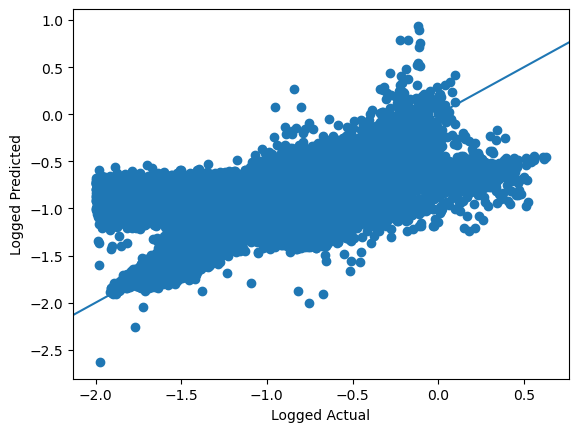

<Figure size 640x480 with 0 Axes>

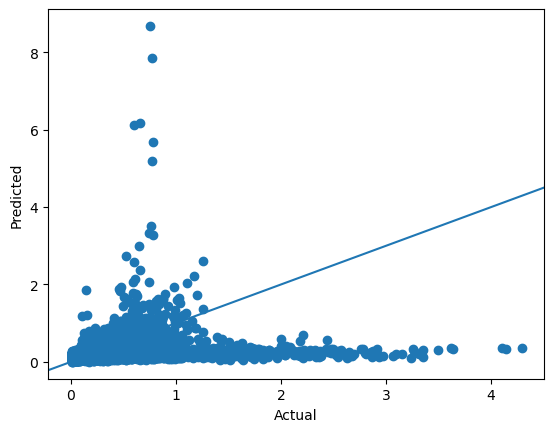

chl
Index(['PC_1', 'PC_3', 'PC_5', 'PC_8'], dtype='object')
coefs_mn: [ 1.93488171 -3.14234957 -2.63294693  5.84044609]
coefs_std: [0.0473699  0.04526473 0.01805647 0.04110876]
int: -1.1832919874893193
mean r2: 0.4287230653525203
mean bias: 2.2701627512469054e-06
mean mae: 0.20543771645913103


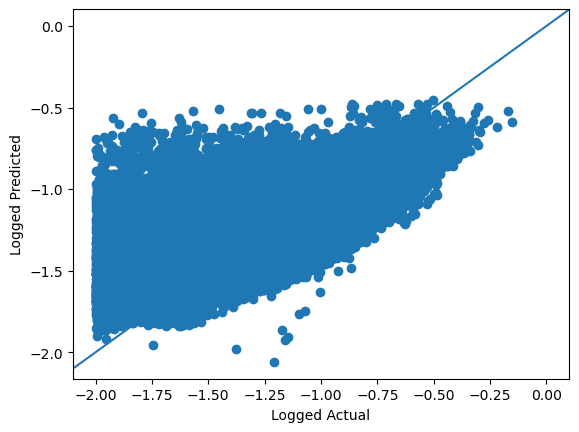

<Figure size 640x480 with 0 Axes>

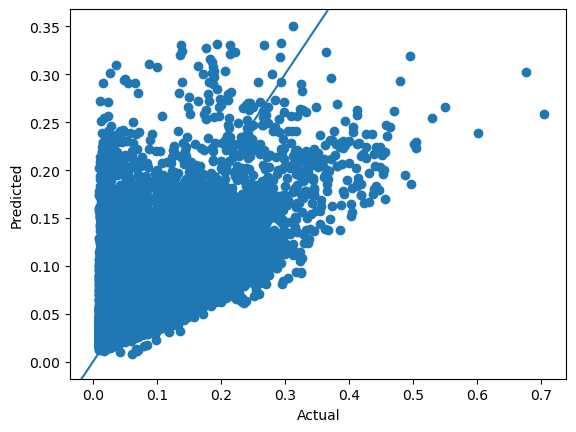

dia
Index(['PC_1', 'PC_2', 'PC_5', 'PC_8'], dtype='object')
coefs_mn: [ 20.70953899 -15.26146604  -5.82223807   5.44159238]
coefs_std: [0.09709029 0.06996905 0.0095387  0.02284909]
int: -21.9182614908571
mean r2: 0.38570015893899184
mean bias: -1.2243337603049638e-06
mean mae: 0.31172165912358807


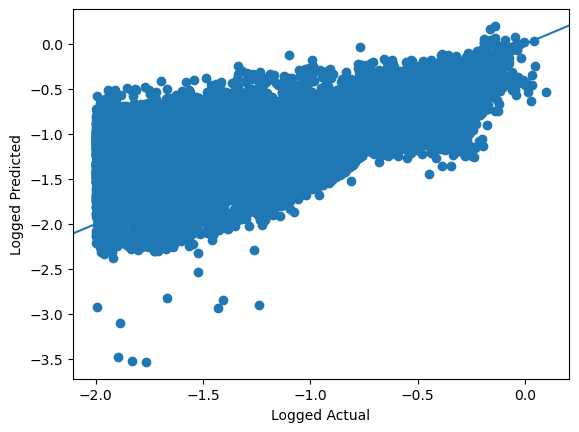

<Figure size 640x480 with 0 Axes>

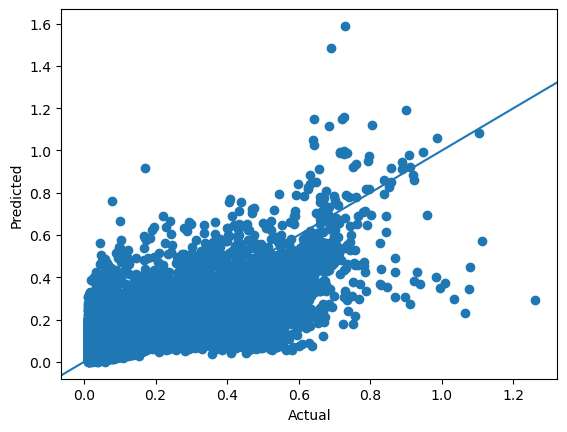

coc
Index(['PC_4', 'PC_5', 'PC_6', 'PC_8'], dtype='object')
coefs_mn: [-11.05561658  -3.72290679   7.21756934  10.70058006]
coefs_std: [0.10404047 0.04144089 0.10293719 0.05038112]
int: 8.323556790103877
mean r2: 0.292467611204521
mean bias: 1.1308794516144844e-06
mean mae: 0.3072793065614365


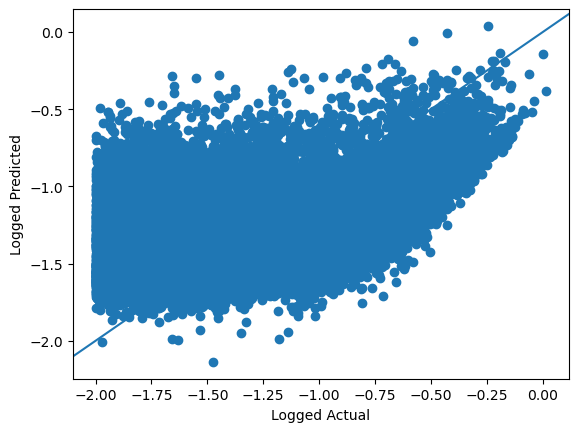

<Figure size 640x480 with 0 Axes>

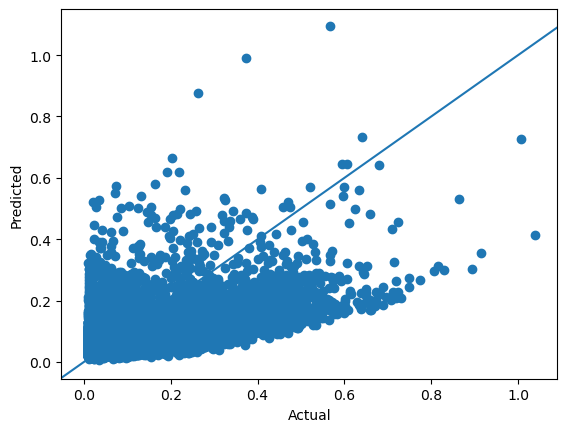

cya
Index(['PC_1', 'PC_2', 'PC_6', 'PC_8'], dtype='object')
coefs_mn: [-6.3230088  12.48718367 -3.01531025 -2.93241526]
coefs_std: [0.1723614  0.18563466 0.02510467 0.03042822]
int: 6.426638217156975
mean r2: 0.6041365860889896
mean bias: 2.4876957229709385e-06
mean mae: 0.09107520092940048


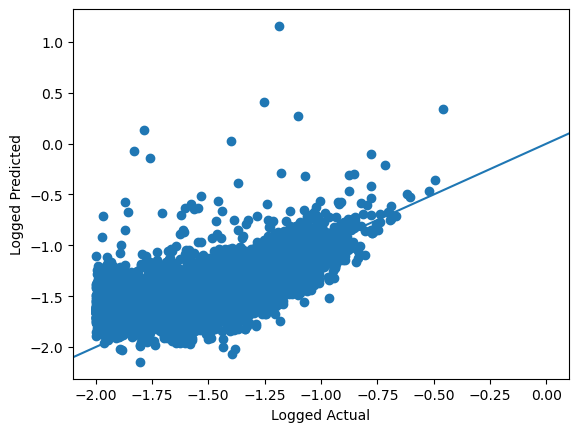

<Figure size 640x480 with 0 Axes>

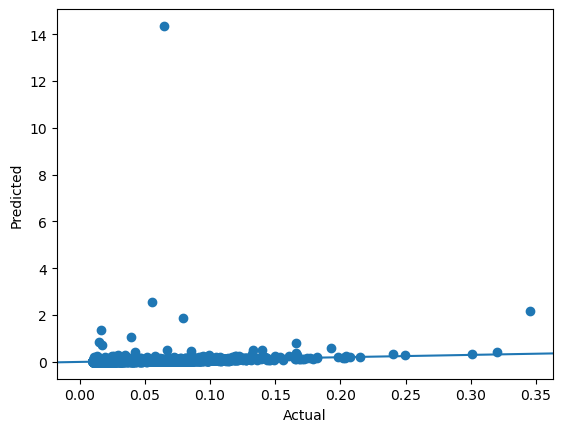

din
Index(['PC_3', 'PC_5', 'PC_7', 'PC_8'], dtype='object')
coefs_mn: [  6.21900931  14.75705162 -12.23394721 -15.33345471]
coefs_std: [0.32584691 1.02192077 0.92495043 0.62369929]
int: -11.766546555691443
mean r2: 0.1535475968215608
mean bias: -4.9719143796674285e-05
mean mae: 0.30686059416063977


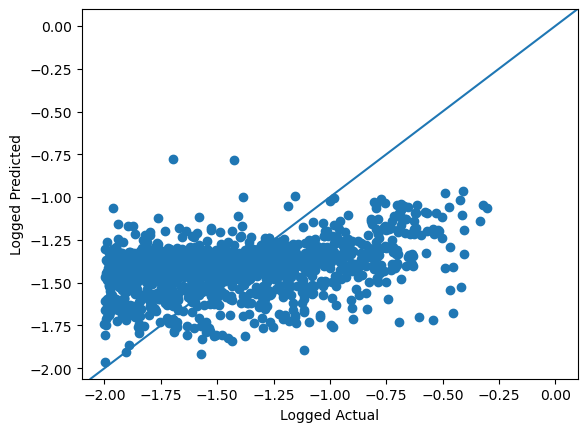

<Figure size 640x480 with 0 Axes>

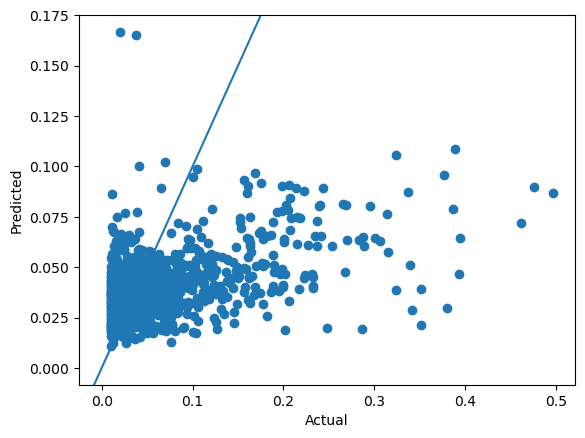

pha
Index(['PC_1', 'PC_4', 'PC_7', 'PC_8'], dtype='object')
coefs_mn: [-12.91263301  19.19327359  -5.41744992  -7.91920299]
coefs_std: [0.08981172 0.10944738 0.04178981 0.02624329]
int: 27.476901159363024
mean r2: 0.3378428806845358
mean bias: 2.9196939059293493e-06
mean mae: 0.3085297708426711


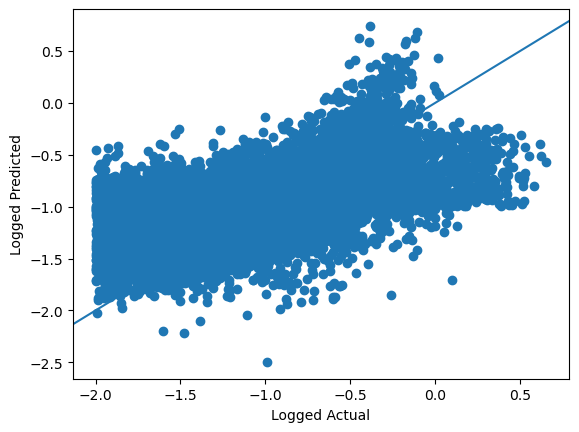

<Figure size 640x480 with 0 Axes>

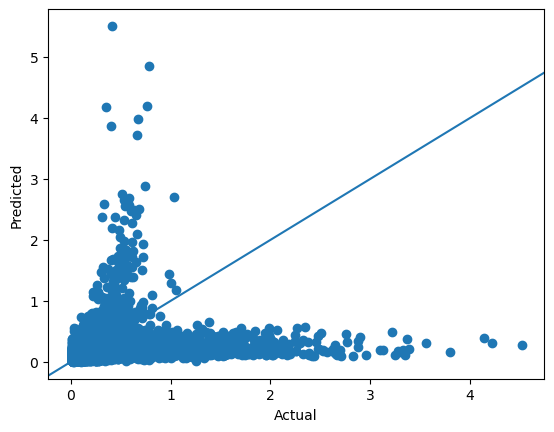

In [154]:
phyto_dats = [tot_dat, chl_dat, dia_dat, coc_dat, cya_dat, din_dat, pha_dat] 

for i in range(len(phyto_dats)):
    MLR_no_env(phyto_dat=phyto_dats[i]) 
